# **DataVisualisation**

## Objectives

- Fetch data from Kaggle, save as raw data and prepare it for further processes.

## Inputs

- Kaggle JSON file - the token is required for kaggle authentication. 

## Outputs

- Generate the Dataset: inputs/cherry_leaves_dataset.

## Additional Comments

- No additional comments here.


---


# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

Change the working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory



You set a new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-in-cherry-leaves'

---

### Set input directories

Set train,validation and test paths

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [7]:

labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualization of image

---

## Determine Average Images Size on Train Set

Compute average images size on train set.

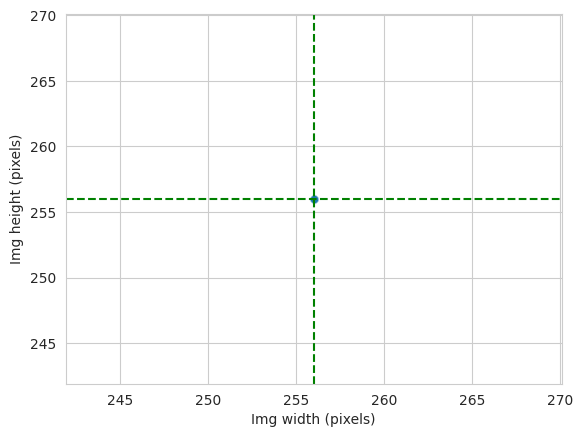

Img width average: 256 
Img height average: 256


In [10]:
dim1, dim2 = [], []
for label in labels:
    for img_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + img_filename)
        d1, d2, colors = img.shape
        dim1.append(d1) 
        dim2.append(d2) 

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Img width (pixels)")
axes.set_ylabel("Img height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='g', linestyle='--')
axes.axhline(y=dim2_mean, color='g', linestyle='--')
plt.show()
print(f"Img width average: {dim2_mean} \nImg height average: {dim1_mean}")


Bar plot to confirm the average image size on the train set.

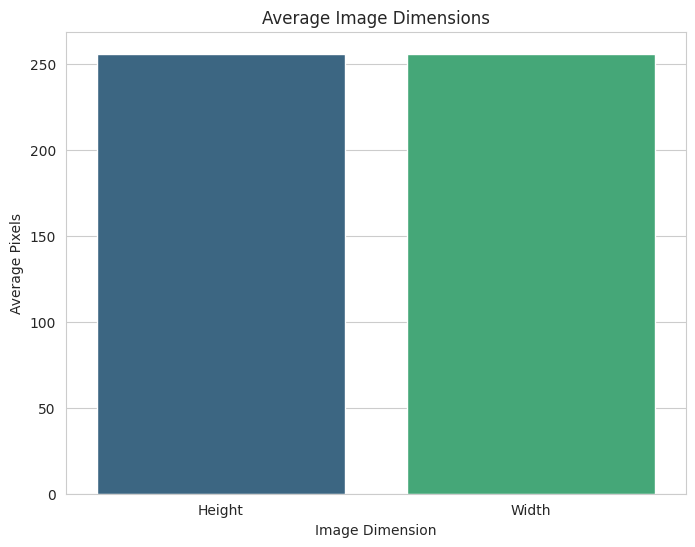

Img width average: 256 
Img height average: 256


In [12]:
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())

dimensions = ['Height', 'Width']
mean_values = [dim1_mean, dim2_mean]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x=dimensions, y=mean_values, palette='viridis', ax=ax)
ax.set_xlabel("Image Dimension")
ax.set_ylabel("Average Pixels")
ax.set_title("Average Image Dimensions")

plt.show()
print(f"Img width average: {dim2_mean} \nImg height average: {dim1_mean}")

### Images Size For Training The Model Is The Average From All images In The Train Set.

In [13]:
img_shape = (dim1_mean, dim2_mean, 3)
img_shape

(256, 256, 3)

In [14]:

joblib.dump(value=img_shape ,
            filename=f"{file_path}/img_shape.pkl")

['outputs/v1/img_shape.pkl']

---


# Average & Variability Of Images Per Label

Function To Load Images In An Array (Tensor)

In [15]:
from tensorflow.keras.preprocessing import image

def load_img_as_tensor(my_data_dir, new_size=(50, 50), nr_imgs_per_label=20):
    """
    Loads the images as tensors from the specified directory and 
    returns arrays of image data (X) and labels (y)
    """
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for img_filename in os.listdir(os.path.join(my_data_dir, label)):
            if counter < nr_imgs_per_label:
                img_path = os.path.join(my_data_dir, label, img_filename)
                img = image.load_img(img_path, target_size=new_size)
                img_array = image.img_to_array(img)

                if img_array.max() > 1:
                    img_resized = img_array / 255.0
                else:
                    img_resized = img_array

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

Load Image Shapes & Labels In An Array

In [16]:
X, y = load_img_as_tensor(my_data_dir=train_path,
                           new_size=img_shape,
                           nr_imgs_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot & Save Mean & Variability Of Images Per Label

In [17]:
def plot_avg_variance_per_label(X, y, figsize=(12, 5), save_img=False):
    """
    Plots the average and variance of images for each label.
    """
    for displayed_label in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == displayed_label, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label for {displayed_label} leaves ====")
        print(f"The image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {displayed_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {displayed_label}")
        axes[1].imshow(std_img, cmap='gray')

        if save_img:
            plt.savefig(f"{file_path}/avg_var_{displayed_label}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label for healthy leaves ====
The image Shape: (256, 256, 3)
==== Label for powdery_mildew leaves ====
The image Shape: (256, 256, 3)


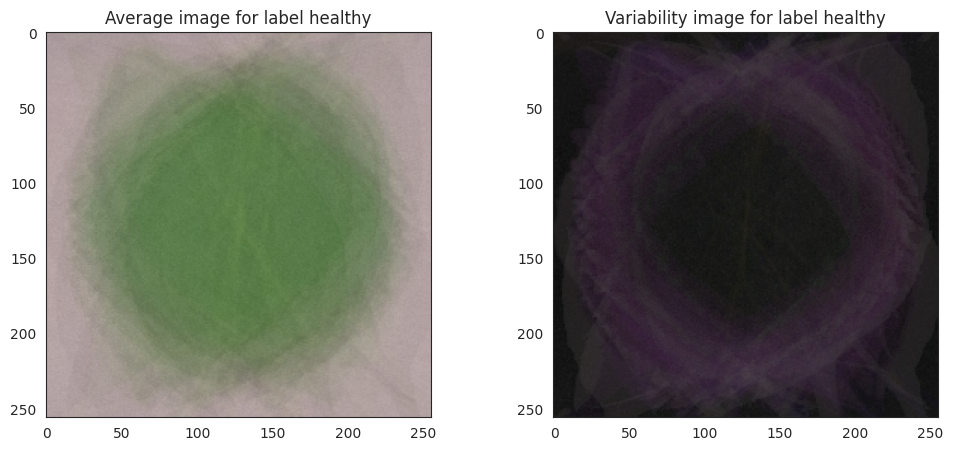

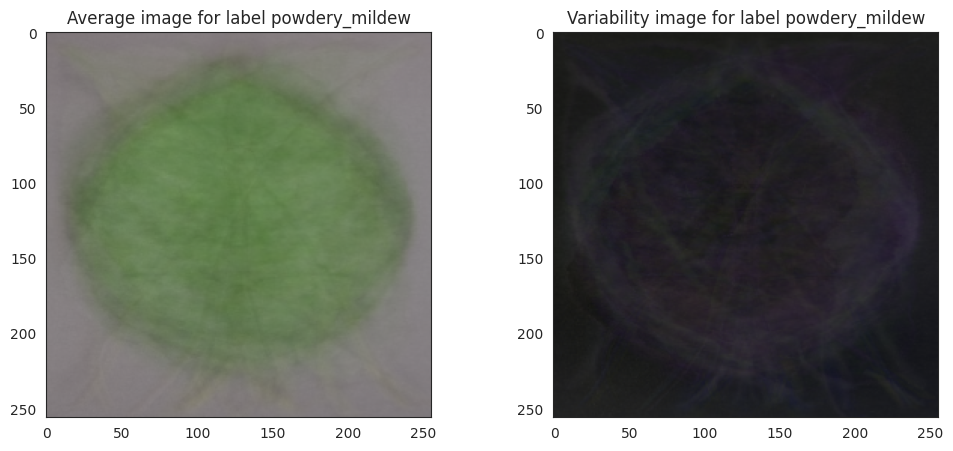

In [18]:
plot_avg_variance_per_label(X=X, y=y, figsize=(12, 5), save_img=True, )

# Addressing The Differences Between The Average Infected & Healthy Cherry Leaves

In [19]:
def subset_label_img(X, y, displayed_label):
    """
    This function returns a subset of images corresponding to the specified label.
    """
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == displayed_label, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def avg_label_diff_data_array(X, y, label1, label2, figsize=(20, 5), save_img=False):
    """
    Verifies the presence of the labels within the set of unique labels
    Computes the mean and difference between label1 and label2
    Generates a chart and saves it.
    """
    sns.set_style("white")

    if (label1 not in np.unique(y)) or (label2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label2}, are not in {np.unique(y)} ")
        return

    imgs_label = subset_label_img(X, y, label1)
    label1_avg = np.mean(imgs_label, axis=0)

    imgs_label = subset_label_img(X, y, label2)
    label2_avg = np.mean(imgs_label, axis=0)

    diff_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average of {label1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average of {label2}')
    axes[2].imshow(diff_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label1} & {label2}')
    if save_img:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


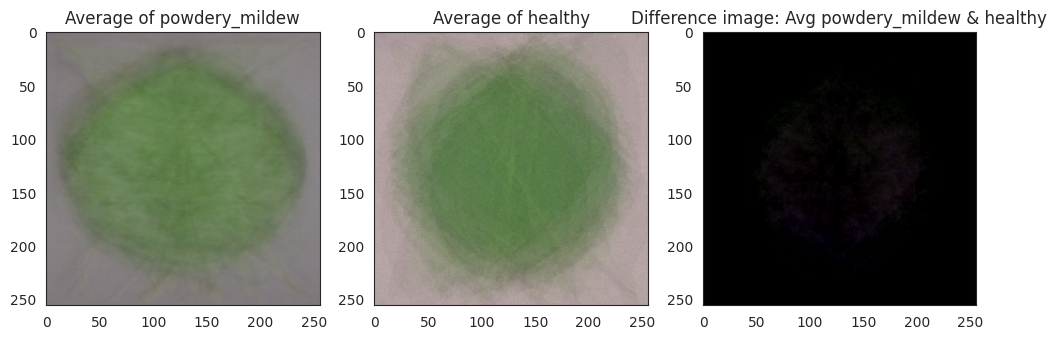

In [20]:
avg_label_diff_data_array(X=X, y=y,label1='powdery_mildew',
                          label2='healthy', figsize=(12, 10),
                          save_img=True
                          )